In [1]:
import os
import pandas as pd

# Sets the path to the parent directory of RR classes
os.chdir("//home//skowron//Desktop//RRcourse2023//6. Coding and documentation")

# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv("Data//onet_tasks.csv")
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)

# sheets = ["ISCO1", "ISCO2", "ISCO3", "ISCO4", "ISCO5", "ISCO6", "ISCO7", "ISCO8", "ISCO9"]

for i in range(1,10):
    globals()["isco"+str(i)] = pd.read_excel("Data//Eurostat_employment_isco.xlsx", sheet_name="ISCO"+str(i))

# We will focus on three countries, but perhaps we could clean this code to allow it
# to easily run for all the countries in the sample?

# This will calculate worker totals in each of the chosen countries.
for country in ['Belgium', 'Spain', 'Poland']:
    globals()["total_"+country] = 0
    for i in range(1,10):
        globals()["total_"+country] += globals()["isco"+str(i)][country]

In [2]:
# Let's merge all these datasets. We'll need a column that stores the occupation categories:
all_data = pd.DataFrame()
for i in range(1, 10):
    sheet_name = f"ISCO{i}"
    df = pd.read_excel("Data//Eurostat_employment_isco.xlsx", sheet_name=sheet_name)
    df['ISCO'] = i
    all_data = pd.concat([all_data, df], ignore_index=True)

# We have 9 occupations and the same time range for each, so we can add the totals by
# adding a vector that is 9 times the previously calculated totals
totals = {}
for country in all_data.columns[2:]:
    totals[country] = all_data[country].sum()

# And this will give us shares of each occupation among all workers in a period-country
for country, total in totals.items():
    all_data[f"total_{country}"] = total
    all_data[f"share_{country}"] = all_data[country] / total

In [3]:
# Now let's look at the task data. We want the first digit of the ISCO variable only
import pandas as pd
import numpy as np
import re

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:



In [4]:
from scipy.stats import gmean
#first task item

def standardize_column(combined, column, country):
    temp_mean = np.average(combined[column], weights=combined[f"share_{country}"])
    temp_sd = np.sqrt(np.average((combined[column] - temp_mean) ** 2, weights=combined[f"share_{country}"]))
    combined[f"std_{country}_{column}"] = (combined[column] - temp_mean) / temp_sd

columns = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]
countries = ["Belgium", "Poland", "Spain"]

for col in columns:
    for country in countries:
        standardize_column(combined, col, country)

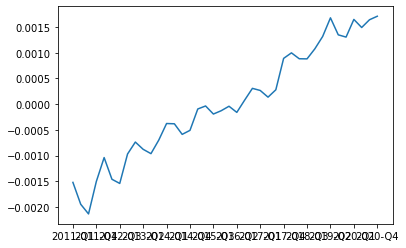

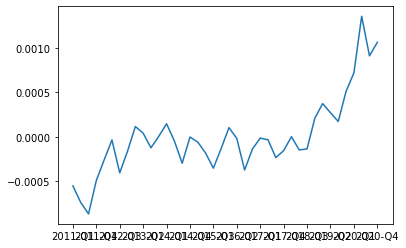

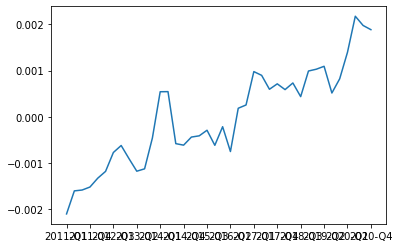

In [5]:
countries = ["Poland", "Spain", "Belgium"]
# Loop through the countries to calculate NRCA and standardize it

for country in countries:
    combined[f"{country}_NRCA"] = combined[f"std_{country}_t_4A2a4"] + combined[f"std_{country}_t_4A2b2"] + combined[f"std_{country}_t_4A4a1"]
    temp_mean = np.average(combined[f"{country}_NRCA"], weights=combined[f"share_{country}"])
    temp_sd = np.sqrt(np.average((combined[f"{country}_NRCA"] - temp_mean)**2, weights=combined[f"share_{country}"]))
    combined[f"std_{country}_NRCA"] = (combined[f"{country}_NRCA"] - temp_mean) / temp_sd
#     Calculate the weighted sum of NRCA for each country over time

import matplotlib.pyplot as plt
for country in countries:
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]
    agg_country = combined.groupby(["TIME"])[f"multip_{country}_NRCA"].sum().reset_index()
    plt.plot(agg_country["TIME"], agg_country[f"multip_{country}_NRCA"])
    plt.xticks(range(0, len(agg_country), 3), agg_country["TIME"][::3])
    plt.show()